**Deuxième réseau** :  
     - Similaire au premier, mais avec deux changements majeurs :  
       - Les images sont redimensionnées à 32x32 pixels.  
       - Utilisation d'un générateur de données (DataGen) pour augmenter les données via des rotations, inversions (flip), ajustements de contraste et de luminosité.  
       - Validation croisée à 10 plis  
     - Classes: ['NORMAL', 'PNEUMONIA']

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import collections
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

from keras.layers import Dropout


#Wilcoxon Test
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import wilcoxon

#Utilizado para guardar modelos y cargarlos
import joblib

import shap

import cv2

#Entrenamiento
batch_size = 64
nb_classes = 2
epochs = 50
crossValidationSplit = 10
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

In [2]:
def preprocesar_imagen(imagen_path):
    # Cargar la imagen utilizando OpenCV
    imagen = cv2.imread(imagen_path)

    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    alpha = 1.3  # factor de contraste
    beta = -80    # factor de brillo
    imagen_ajustada = cv2.convertScaleAbs(imagen_gris, alpha=alpha, beta=beta)

    imagen_final = cv2.resize(imagen_ajustada, (img_rows, img_cols), interpolation=cv2.INTER_AREA)

    return imagen_final


In [4]:
def load_data(ruta):
    name_classes = ['NORMAL', 'PNEUMONIA']
    X, y = [], []

    # Listar las carpetas principales
    base_dirs = [ruta + r'\train', ruta + r'\val', ruta + r'\test']

    for base_dir in base_dirs:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            path = rf'{base_dir}\{class_name}\*.jpeg'
            for filename in glob.glob(path):
                im = preprocesar_imagen(filename)
                X.append(image.img_to_array(im))
                
                # Determinar la clase en función del nombre del archivo
                if class_name == 'NORMAL':
                    y.append(0)  # Clase 0: NORMAL
                else:
                    y.append(1)  # Clase 1: PNEUMONIA_BACTERIA

    input_shape = (img_rows, img_cols, 1)
    return np.array(X), np.array(y), input_shape


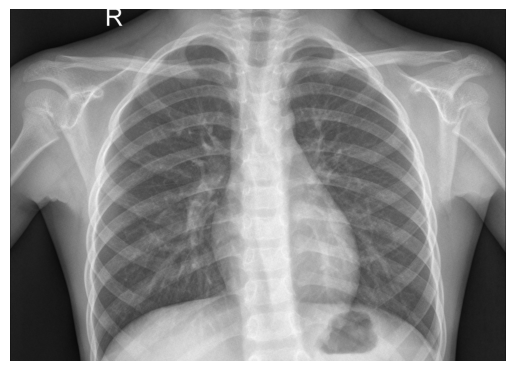

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

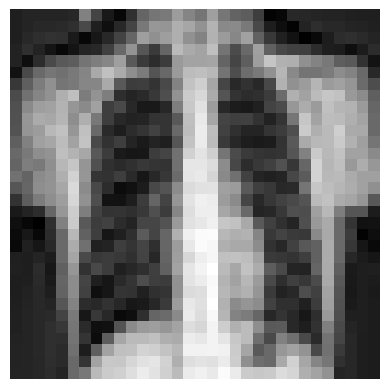

In [5]:
imagen = r"..\data\external\chest_xray\test\NORMAL\IM-0001-0001.jpeg"

normal = cv2.imread(imagen)

plt.imshow(normal)
plt.axis('off')  # Opcional: quita los ejes de la imagen
plt.show()


imagen_retocada = preprocesar_imagen(imagen)

plt.imshow(imagen_retocada, cmap='gray')  # Añadir cmap='gray'
plt.axis('off')  

In [6]:
def cnn_model(input_shape,nb_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Rescaling(1. / 255)(inputs)

    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(nb_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [7]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(n, 3))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,0])
        plt.gray()
        ax.set_title('{}-{}'.format(y[index[i]],index[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [8]:
def enregistrer_tableau_dans_txt(tableau, nom_fichier):
    """
    Enregistre les éléments d'un tableau dans un fichier .txt.

    Args:
        tableau (list): Liste des éléments à enregistrer.
        nom_fichier (str): Nom du fichier (doit inclure l'extension .txt).
    
    Returns:
        None
    """
    try:
        # Ouvrir le fichier en mode écriture
        with open(nom_fichier, 'w', encoding='utf-8') as fichier:
            # Écrire chaque élément du tableau sur une nouvelle ligne
            for element in tableau:
                fichier.write(str(element) + '\n')
        print(f"Tableau enregistré avec succès dans '{nom_fichier}'")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement du fichier : {e}")

(5856, 32, 32, 1) échantillons d'entraînement
32 x 32 taille de l'image
(32, 32, 1) input_shape
50 epochs


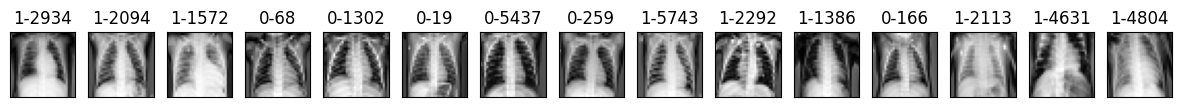

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 47ms/step - accuracy: 0.7297 - loss: 0.5843 - val_accuracy: 0.8328 - val_loss: 0.5887
Epoch 2/50
82/82 - 0s - 2ms/step - accuracy: 0.7812 - loss: 0.5214 - val_accuracy: 0.8635 - val_loss: 0.5503
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.8279 - loss: 0.3812 - val_accuracy: 0.8908 - val_loss: 0.2819
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.9062 - loss: 0.2583 - val_accuracy: 0.8891 - val_loss: 0.2873
Epoch 5/50
82/82 - 2s - 24ms/step - accuracy: 0.8688 - loss: 0.3056 - val_accuracy: 0.8584 - val_loss: 0.3194
Epoch 6/50
82/82 - 0s - 2ms/step - accuracy: 0.8438 - loss: 0.3540 - val_accuracy: 0.8908 - val_loss: 0.2607
Epoch 7/50
82/82 - 2s - 24ms/step - accuracy: 0.8861 - loss: 0.2707 - val_accuracy: 0.8891 - val_loss: 0.2587
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9531 - loss: 0.1824 - val_accuracy: 0.8976 - val_loss: 0.2496
Epoch 9/50
82/82 - 2s - 23ms/step - accuracy: 0.9005 - loss: 0.2510 - val_accuracy: 0.9147 - val_loss: 0.2065
Epoch 10/

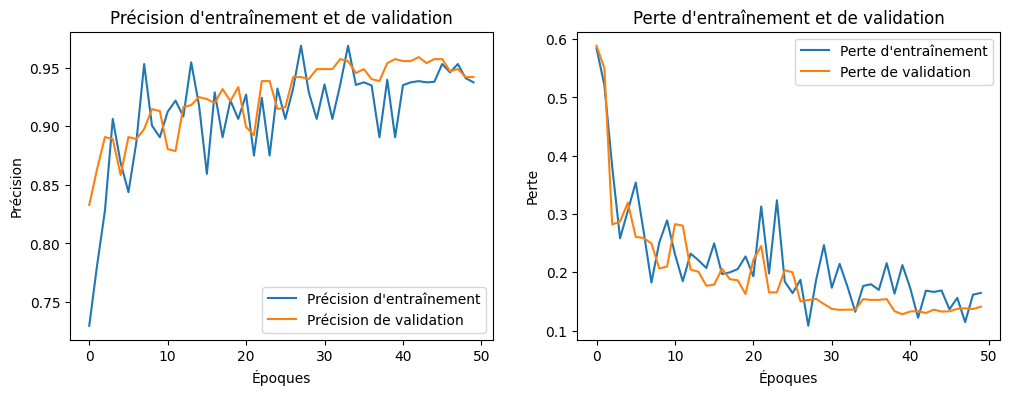

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9378 - loss: 0.1407 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 1:
perte: 0.14 précision: 0.94
AUC 0.9866
Prédictions
Counter({np.int64(1): 445, np.int64(0): 141}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.84      0.89       159
   Pneumonia       0.94      0.98      0.96       427

    accuracy                           0.94       586
   macro avg       0.94      0.91      0.92       586
weighted avg       0.94      0.94      0.94       586

Matrice de confusion


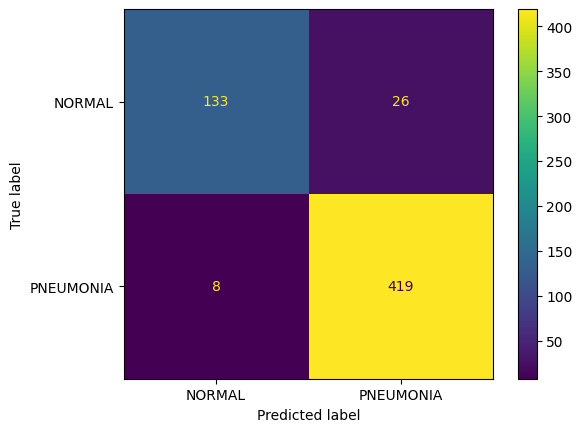

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7261 - loss: 0.5670 - val_accuracy: 0.9044 - val_loss: 0.4420
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.8438 - loss: 0.3692 - val_accuracy: 0.8652 - val_loss: 0.4683
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.8471 - loss: 0.3509 - val_accuracy: 0.8515 - val_loss: 0.2994
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7812 - loss: 0.3741 - val_accuracy: 0.8208 - val_loss: 0.3557
Epoch 5/50
82/82 - 2s - 23ms/step - accuracy: 0.8744 - loss: 0.2918 - val_accuracy: 0.8857 - val_loss: 0.2557
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.9688 - loss: 0.1703 - val_accuracy: 0.9198 - val_loss: 0.2040
Epoch 7/50
82/82 - 2s - 24ms/step - accuracy: 0.8894 - loss: 0.2728 - val_accuracy: 0.8754 - val_loss: 0.2659
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.7969 - loss: 0.3997 - val_accuracy: 0.8840 - val_loss: 0.2512
Epoch 9/50
82/82 - 2s - 24ms/step - accuracy: 0.8926 - loss: 0.2659 - val_accuracy: 0.9369 - val_loss: 0.1795
Epoch 10/

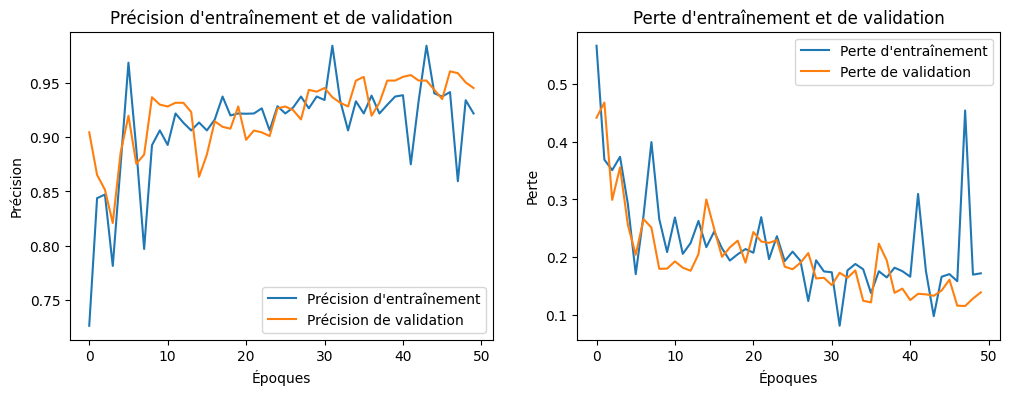

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9551 - loss: 0.1201 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 2:
perte: 0.14 précision: 0.95
AUC 0.9886
Prédictions
Counter({np.int64(1): 409, np.int64(0): 177}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.86      0.96      0.90       159
   Pneumonia       0.98      0.94      0.96       427

    accuracy                           0.95       586
   macro avg       0.92      0.95      0.93       586
weighted avg       0.95      0.95      0.95       586

Matrice de confusion


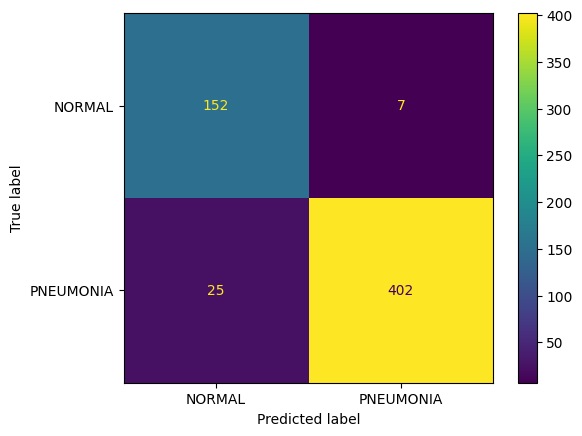

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7336 - loss: 0.5570 - val_accuracy: 0.7713 - val_loss: 0.4959
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7969 - loss: 0.4440 - val_accuracy: 0.8737 - val_loss: 0.4075
Epoch 3/50
82/82 - 2s - 24ms/step - accuracy: 0.8519 - loss: 0.3341 - val_accuracy: 0.8618 - val_loss: 0.2916
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.8594 - loss: 0.2995 - val_accuracy: 0.8464 - val_loss: 0.3133
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.8769 - loss: 0.2824 - val_accuracy: 0.8635 - val_loss: 0.2839
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.2777 - val_accuracy: 0.8601 - val_loss: 0.2857
Epoch 7/50
82/82 - 2s - 26ms/step - accuracy: 0.8861 - loss: 0.2763 - val_accuracy: 0.9249 - val_loss: 0.2076
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.8594 - loss: 0.3753 - val_accuracy: 0.9249 - val_loss: 0.2084
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8928 - loss: 0.2659 - val_accuracy: 0.8191 - val_loss: 0.3642
Epoch 10/

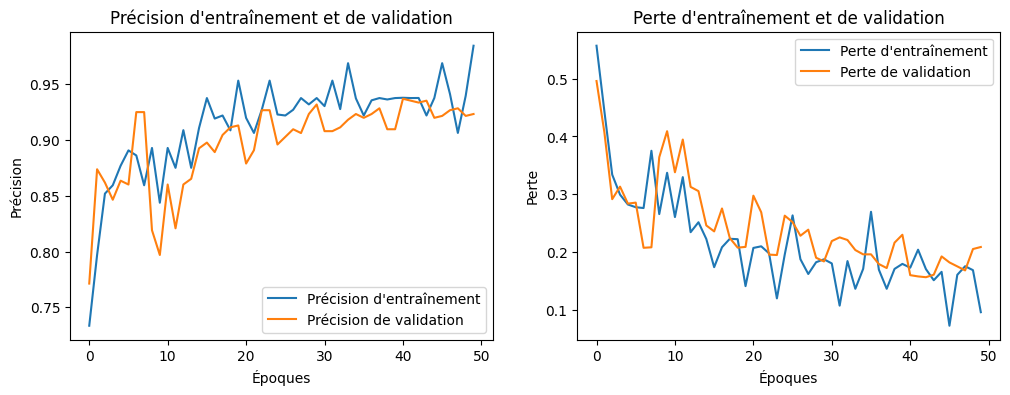

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9396 - loss: 0.1699
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 3:
perte: 0.21 précision: 0.92
AUC 0.9788
Prédictions
Counter({np.int64(1): 398, np.int64(0): 188}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.80      0.95      0.87       159
   Pneumonia       0.98      0.91      0.95       427

    accuracy                           0.92       586
   macro avg       0.89      0.93      0.91       586
weighted avg       0.93      0.92      0.93       586

Matrice de confusion


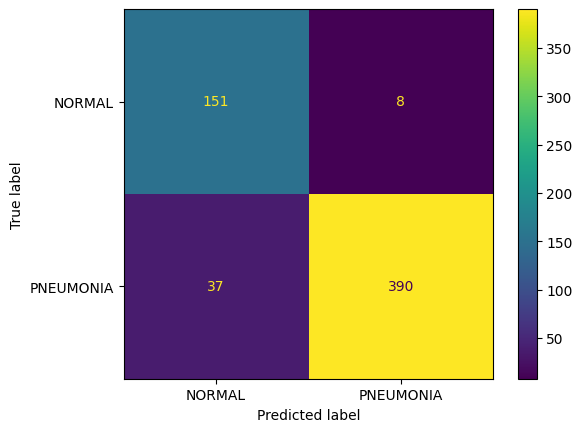

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.7265 - loss: 0.5907 - val_accuracy: 0.7304 - val_loss: 0.4933
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7031 - loss: 0.5800 - val_accuracy: 0.7304 - val_loss: 0.4924
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.8106 - loss: 0.4016 - val_accuracy: 0.8208 - val_loss: 0.3486
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.8438 - loss: 0.3095 - val_accuracy: 0.8174 - val_loss: 0.3636
Epoch 5/50
82/82 - 2s - 24ms/step - accuracy: 0.8711 - loss: 0.3021 - val_accuracy: 0.8515 - val_loss: 0.2977
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8594 - loss: 0.3840 - val_accuracy: 0.7782 - val_loss: 0.4033
Epoch 7/50
82/82 - 2s - 26ms/step - accuracy: 0.8838 - loss: 0.2736 - val_accuracy: 0.9369 - val_loss: 0.1930
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.7812 - loss: 0.4426 - val_accuracy: 0.9369 - val_loss: 0.1958
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8905 - loss: 0.2684 - val_accuracy: 0.8396 - val_loss: 0.3098
Epoch 10/

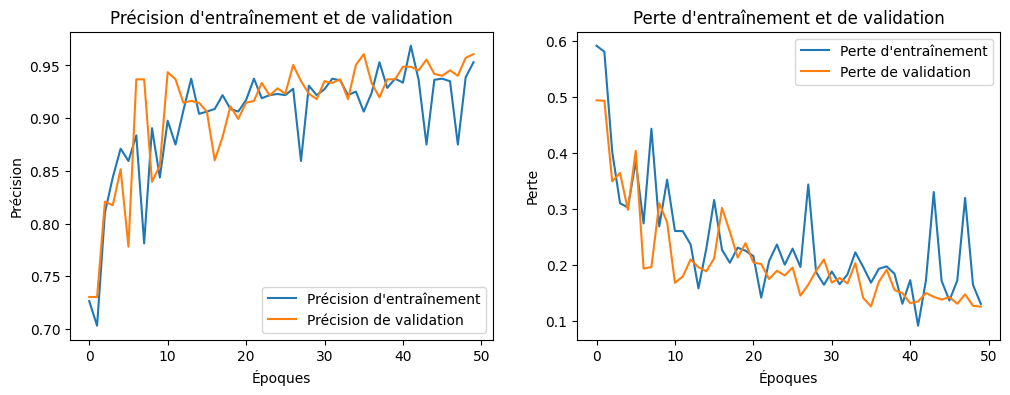

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.1254
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 4:
perte: 0.13 précision: 0.96
AUC 0.9891
Prédictions
Counter({np.int64(1): 431, np.int64(0): 155}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.94      0.92      0.93       158
   Pneumonia       0.97      0.98      0.97       428

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586

Matrice de confusion


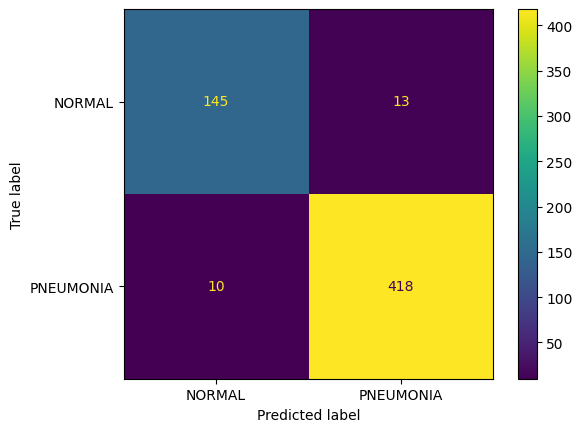

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7276 - loss: 0.5705 - val_accuracy: 0.7321 - val_loss: 0.4664
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7500 - loss: 0.4023 - val_accuracy: 0.7509 - val_loss: 0.4286
Epoch 3/50
82/82 - 2s - 23ms/step - accuracy: 0.8360 - loss: 0.3601 - val_accuracy: 0.7611 - val_loss: 0.4373
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7969 - loss: 0.4753 - val_accuracy: 0.7816 - val_loss: 0.3994
Epoch 5/50
82/82 - 2s - 24ms/step - accuracy: 0.8700 - loss: 0.3043 - val_accuracy: 0.9334 - val_loss: 0.1951
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.9062 - loss: 0.2603 - val_accuracy: 0.9317 - val_loss: 0.1943
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8801 - loss: 0.2897 - val_accuracy: 0.9249 - val_loss: 0.2496
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9062 - loss: 0.2174 - val_accuracy: 0.9096 - val_loss: 0.2764
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8980 - loss: 0.2587 - val_accuracy: 0.9164 - val_loss: 0.2216
Epoch 10/

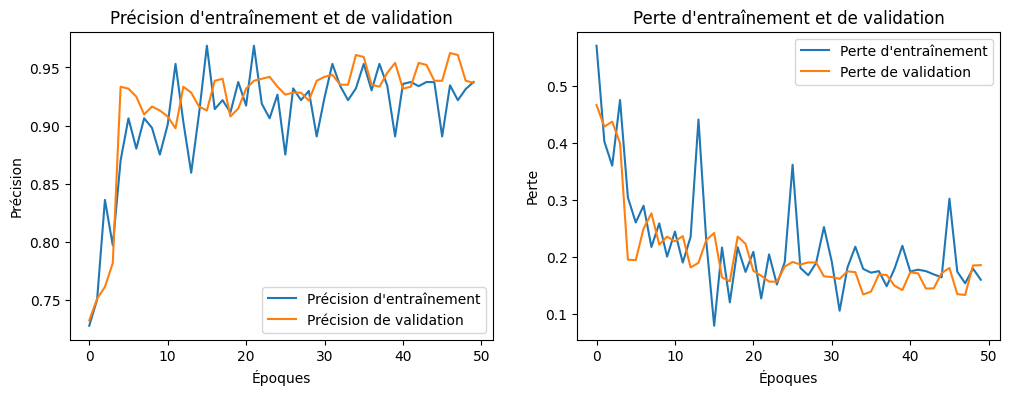

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9498 - loss: 0.1423
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 5:
perte: 0.19 précision: 0.94
AUC 0.9851
Prédictions
Counter({np.int64(1): 401, np.int64(0): 185}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.83      0.97      0.89       158
   Pneumonia       0.99      0.93      0.96       428

    accuracy                           0.94       586
   macro avg       0.91      0.95      0.92       586
weighted avg       0.94      0.94      0.94       586

Matrice de confusion


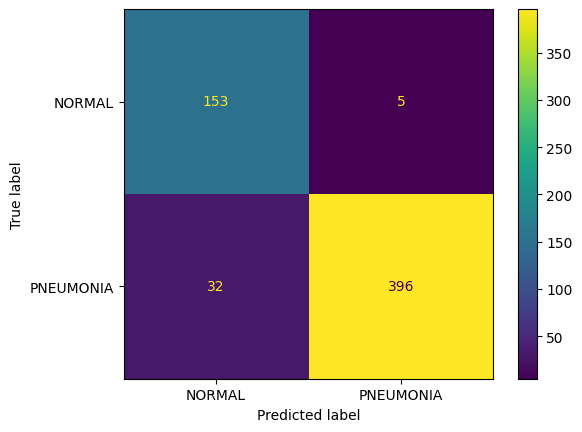

Nombre d'images générées: 5312
x_train (5270, 32, 32, 1) x_test (586, 32, 32, 1)
y_train (5270,) y_test (586,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7288 - loss: 0.5830 - val_accuracy: 0.8430 - val_loss: 0.4337
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7500 - loss: 0.4283 - val_accuracy: 0.8515 - val_loss: 0.5090
Epoch 3/50
82/82 - 2s - 26ms/step - accuracy: 0.8294 - loss: 0.3710 - val_accuracy: 0.8771 - val_loss: 0.2613
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.9531 - loss: 0.1365 - val_accuracy: 0.8976 - val_loss: 0.2424
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.8732 - loss: 0.3070 - val_accuracy: 0.7935 - val_loss: 0.3725
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.2572 - val_accuracy: 0.8396 - val_loss: 0.2974
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8790 - loss: 0.2893 - val_accuracy: 0.8618 - val_loss: 0.2613
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9531 - loss: 0.1796 - val_accuracy: 0.8601 - val_loss: 0.2610
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8944 - loss: 0.2669 - val_accuracy: 0.9488 - val_loss: 0.1591
Epoch 10/

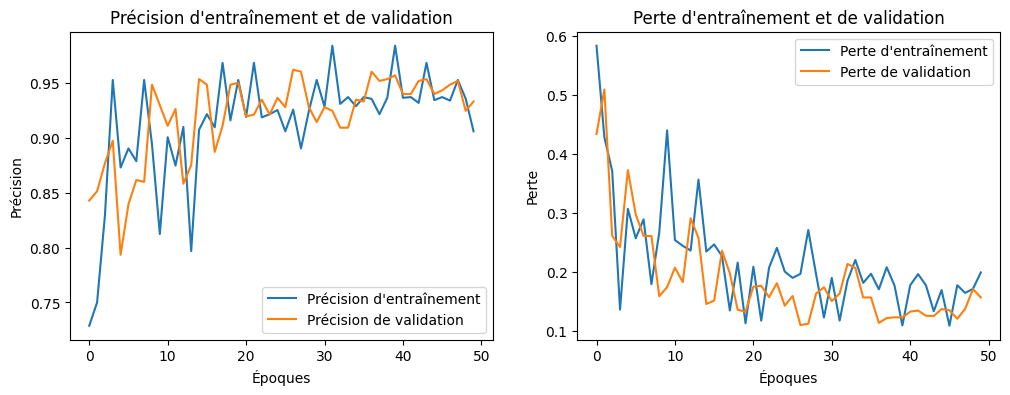

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9500 - loss: 0.1196
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 6:
perte: 0.16 précision: 0.93
AUC 0.9913
Prédictions
Counter({np.int64(1): 397, np.int64(0): 189}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.81      0.97      0.89       158
   Pneumonia       0.99      0.92      0.95       428

    accuracy                           0.93       586
   macro avg       0.90      0.95      0.92       586
weighted avg       0.94      0.93      0.94       586

Matrice de confusion


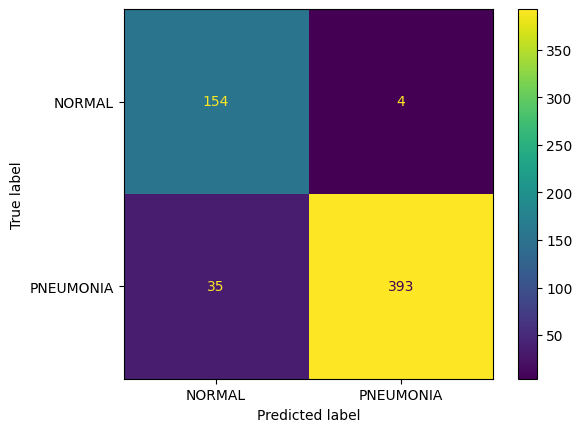

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7283 - loss: 0.5810 - val_accuracy: 0.7299 - val_loss: 0.4239
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7344 - loss: 0.5192 - val_accuracy: 0.7299 - val_loss: 0.4484
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.8143 - loss: 0.3733 - val_accuracy: 0.7863 - val_loss: 0.4067
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.9062 - loss: 0.2608 - val_accuracy: 0.7282 - val_loss: 0.4859
Epoch 5/50
82/82 - 2s - 26ms/step - accuracy: 0.8704 - loss: 0.3037 - val_accuracy: 0.7641 - val_loss: 0.4626
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8750 - loss: 0.2227 - val_accuracy: 0.7641 - val_loss: 0.4574
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8901 - loss: 0.2749 - val_accuracy: 0.8991 - val_loss: 0.2450
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9375 - loss: 0.1603 - val_accuracy: 0.8906 - val_loss: 0.2670
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.9011 - loss: 0.2476 - val_accuracy: 0.8410 - val_loss: 0.3417
Epoch 10/

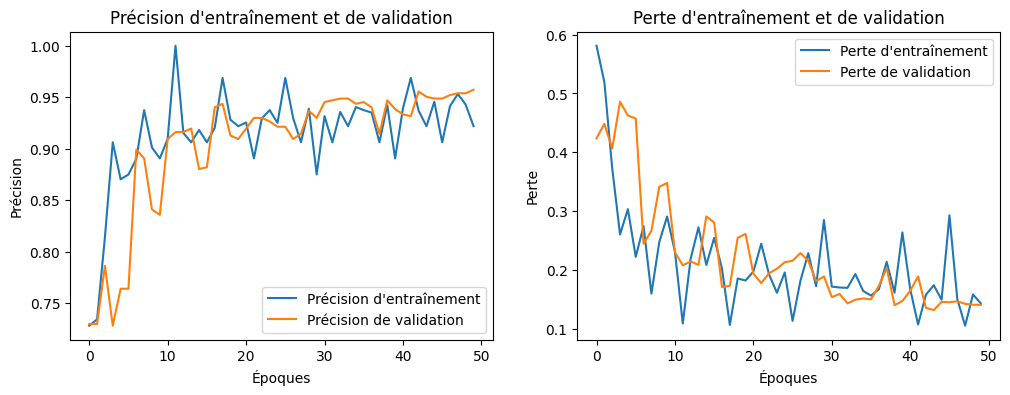

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9677 - loss: 0.1218 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 7:
perte: 0.14 précision: 0.96
AUC 0.9834
Prédictions
Counter({np.int64(1): 422, np.int64(0): 163}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.91      0.94      0.92       158
   Pneumonia       0.98      0.96      0.97       427

    accuracy                           0.96       585
   macro avg       0.94      0.95      0.95       585
weighted avg       0.96      0.96      0.96       585

Matrice de confusion


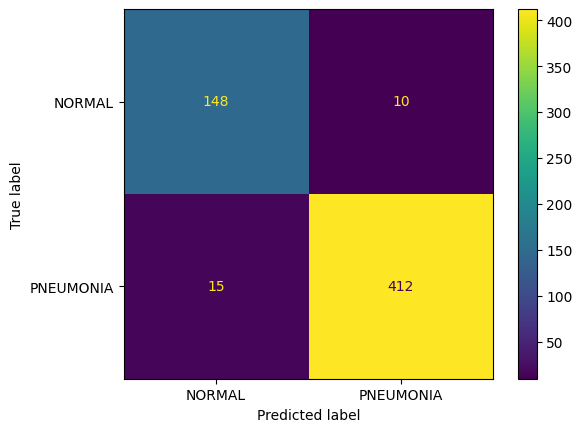

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.7331 - loss: 0.5486 - val_accuracy: 0.8120 - val_loss: 0.4155
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.3048 - val_accuracy: 0.7402 - val_loss: 0.4642
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.8571 - loss: 0.3257 - val_accuracy: 0.9094 - val_loss: 0.2416
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.7969 - loss: 0.4012 - val_accuracy: 0.9162 - val_loss: 0.2529
Epoch 5/50
82/82 - 2s - 26ms/step - accuracy: 0.8901 - loss: 0.2702 - val_accuracy: 0.9026 - val_loss: 0.2458
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.9219 - loss: 0.1887 - val_accuracy: 0.8684 - val_loss: 0.3068
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8894 - loss: 0.2716 - val_accuracy: 0.9299 - val_loss: 0.2091
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9062 - loss: 0.2025 - val_accuracy: 0.9179 - val_loss: 0.2199
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8969 - loss: 0.2504 - val_accuracy: 0.9402 - val_loss: 0.1943
Epoch 10/

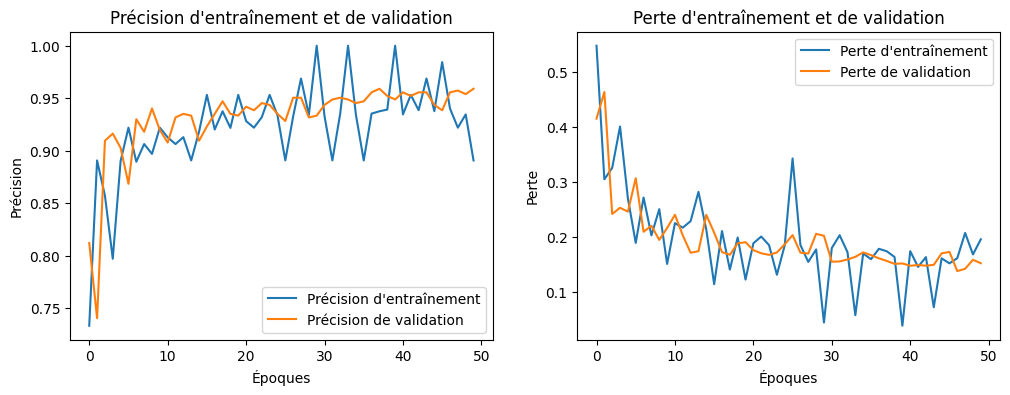

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9703 - loss: 0.1129
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 8:
perte: 0.15 précision: 0.96
AUC 0.9786
Prédictions
Counter({np.int64(1): 427, np.int64(0): 158}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.92      0.92      0.92       158
   Pneumonia       0.97      0.97      0.97       427

    accuracy                           0.96       585
   macro avg       0.95      0.95      0.95       585
weighted avg       0.96      0.96      0.96       585

Matrice de confusion


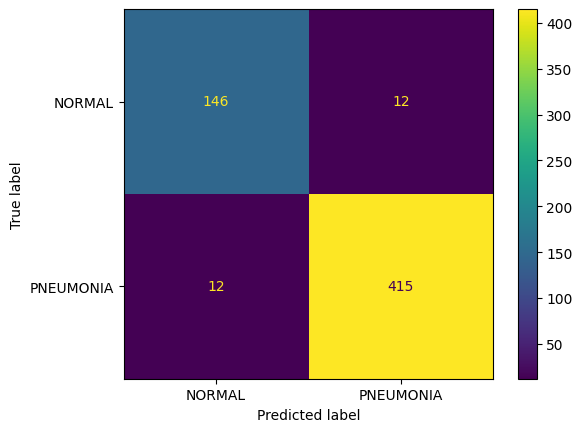

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 45ms/step - accuracy: 0.7254 - loss: 0.5714 - val_accuracy: 0.7402 - val_loss: 0.4299
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.8125 - loss: 0.3795 - val_accuracy: 0.7966 - val_loss: 0.4391
Epoch 3/50
82/82 - 2s - 26ms/step - accuracy: 0.8281 - loss: 0.3801 - val_accuracy: 0.8222 - val_loss: 0.3486
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.2681 - val_accuracy: 0.8769 - val_loss: 0.2709
Epoch 5/50
82/82 - 2s - 24ms/step - accuracy: 0.8652 - loss: 0.3095 - val_accuracy: 0.9026 - val_loss: 0.2446
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.3057 - val_accuracy: 0.8838 - val_loss: 0.2633
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8875 - loss: 0.2723 - val_accuracy: 0.8735 - val_loss: 0.2943
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.9531 - loss: 0.1847 - val_accuracy: 0.8427 - val_loss: 0.3543
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.9021 - loss: 0.2510 - val_accuracy: 0.9094 - val_loss: 0.2161
Epoch 10/

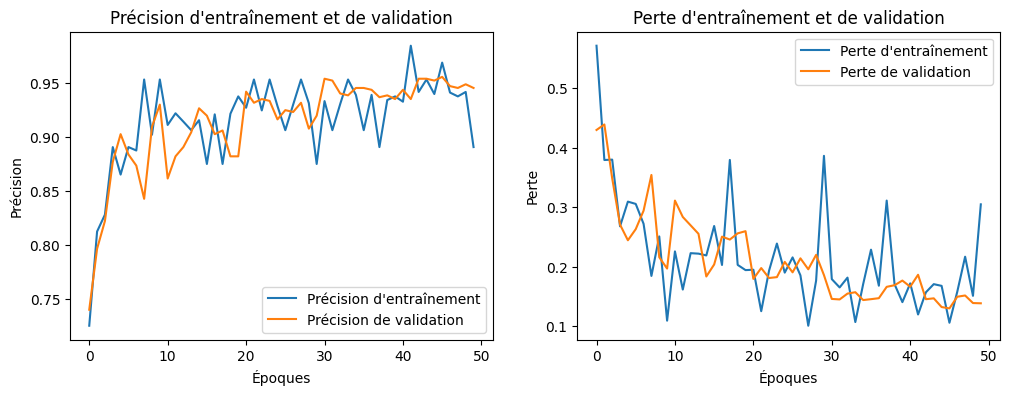

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9582 - loss: 0.1123 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Partition numéro 9:
perte: 0.14 précision: 0.95
AUC 0.9847
Prédictions
Counter({np.int64(1): 419, np.int64(0): 166}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.88      0.92      0.90       158
   Pneumonia       0.97      0.95      0.96       427

    accuracy                           0.95       585
   macro avg       0.93      0.94      0.93       585
weighted avg       0.95      0.95      0.95       585

Matrice de confusion


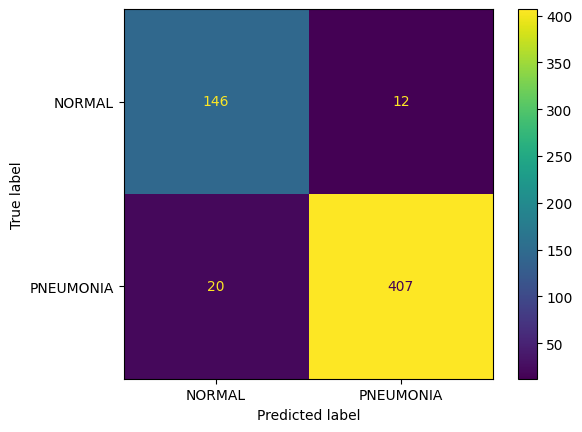

Nombre d'images générées: 5312
x_train (5271, 32, 32, 1) x_test (585, 32, 32, 1)
y_train (5271,) y_test (585,)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 31, 31, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 6, 6, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,634 (1.41 MB)

 Trainable params: 369,634 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
82/82 - 4s - 46ms/step - accuracy: 0.7277 - loss: 0.6020 - val_accuracy: 0.7299 - val_loss: 0.5478
Epoch 2/50
82/82 - 0s - 1ms/step - accuracy: 0.7656 - loss: 0.5216 - val_accuracy: 0.7299 - val_loss: 0.5463
Epoch 3/50
82/82 - 2s - 25ms/step - accuracy: 0.7976 - loss: 0.4117 - val_accuracy: 0.9128 - val_loss: 0.2273
Epoch 4/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.2246 - val_accuracy: 0.9094 - val_loss: 0.2272
Epoch 5/50
82/82 - 2s - 25ms/step - accuracy: 0.8583 - loss: 0.3324 - val_accuracy: 0.8855 - val_loss: 0.2663
Epoch 6/50
82/82 - 0s - 1ms/step - accuracy: 0.8906 - loss: 0.2779 - val_accuracy: 0.9197 - val_loss: 0.2043
Epoch 7/50
82/82 - 2s - 25ms/step - accuracy: 0.8790 - loss: 0.2950 - val_accuracy: 0.8564 - val_loss: 0.3073
Epoch 8/50
82/82 - 0s - 1ms/step - accuracy: 0.8261 - loss: 0.3419 - val_accuracy: 0.8376 - val_loss: 0.3366
Epoch 9/50
82/82 - 2s - 25ms/step - accuracy: 0.8819 - loss: 0.2774 - val_accuracy: 0.8889 - val_loss: 0.2700
Epoch 10/

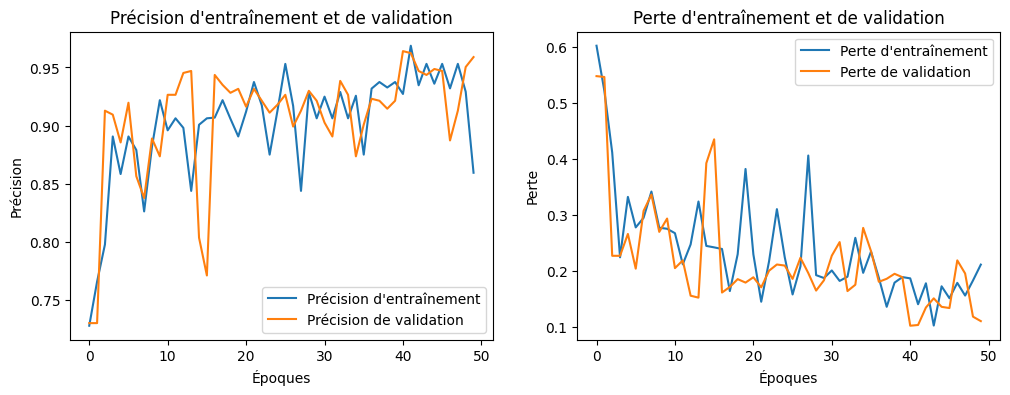

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9648 - loss: 0.1016
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Partition numéro 10:
perte: 0.11 précision: 0.96
AUC 0.9929
Prédictions
Counter({np.int64(1): 417, np.int64(0): 168}) 

Métriques
              precision    recall  f1-score   support

      Normal       0.90      0.96      0.93       158
   Pneumonia       0.98      0.96      0.97       427

    accuracy                           0.96       585
   macro avg       0.94      0.96      0.95       585
weighted avg       0.96      0.96      0.96       585

Matrice de confusion


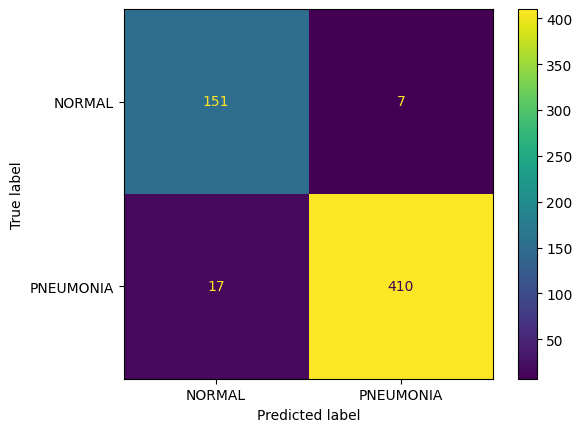

Le meilleur modèle a été sauvegardé avec un ROC de: 0.9929297720333206
Fin de l'entraînement
Résultats ROC:
0.9865818272870547

0.9886291664825534

0.9788490713328326

0.989071927126464

0.9850792618005443

0.991304862179108

0.983399045445113

0.9786410932914356

0.98470340616014

0.9929297720333206

Tableau enregistré avec succès dans '1_2_resultatsROC.txt'


In [9]:
def main(path): 
    resultatsROC = []
    
    X, y, input_shape = load_data(path)

    print(X.shape, 'échantillons d\'entraînement')  # Traducción: train samples
    print(img_rows,'x', img_cols, 'taille de l\'image')  # Traducción: image size
    print(input_shape,'input_shape')
    print(epochs,'epochs')

    plot_symbols(X, y)
    collections.Counter(y)

    # Générer des images
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    # CV-10
    kf = StratifiedKFold(n_splits=crossValidationSplit, shuffle=True, random_state=123)

    splitEntrenamiento = 1
    meilleur_roc = -1  # Para almacenar el mejor valor de ROC
    meilleur_modele = None  # Para guardar el mejor modelo

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)

        print("Nombre d'images générées:", len(train_datagen) * batch_size)  # Traducción: Número de imágenes generadas

        print(f'x_train {X_train.shape} x_test {X_test.shape}')
        print(f'y_train {y_train.shape} y_test {y_test.shape}')

        model = cnn_model(input_shape, nb_classes)
        print(model.summary())

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(train_datagen, steps_per_epoch=len(X_train) // batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)

        # Obtener las métricas del historial
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Graficar la precisión
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Précision d\'entraînement')  # Traducción: Training Accuracy
        plt.plot(val_acc, label='Précision de validation')  # Traducción: Validation Accuracy
        plt.legend()
        plt.title('Précision d\'entraînement et de validation')  # Traducción: Training and Validation Accuracy
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Précision')  # Traducción: Accuracy

        # Graficar la pérdida
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Perte d\'entraînement')  # Traducción: Training Loss
        plt.plot(val_loss, label='Perte de validation')  # Traducción: Validation Loss
        plt.legend()
        plt.title('Perte d\'entraînement et de validation')  # Traducción: Training and Validation Loss
        plt.xlabel('Époques')  # Traducción: Epochs
        plt.ylabel('Perte')  # Traducción: Loss

        plt.show()

        # Visualizar datos del split
        loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
        y_pred = model.predict(X_test)

        # Guardar datos ROC
        roc = roc_auc_score(y_test, y_pred[:, 1])
        resultatsROC.append(roc)

        # Guardar el mejor modelo
        if roc > meilleur_roc:
            meilleur_roc = roc
            meilleur_modele = model

        # Graficas sobre Test
        print(f"Partition numéro {splitEntrenamiento}:")  # Traducción: Split número
        print(f'perte: {loss:.2f} précision: {acc:.2f}')  # Traducción: loss, acc
        print(f'AUC {roc:.4f}')

        print('Prédictions')  # Traducción: Predictions
        y_pred_int = y_pred.argmax(axis=1)
        print(collections.Counter(y_pred_int), '\n')

        print('Métriques')  # Traducción: Metrics
        print(metrics.classification_report(y_test, y_pred_int, target_names=['Normal', 'Pneumonia']))

        print('Matrice de confusion')  # Traducción: Confusion matrix
        metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred_int),
                                       display_labels=['NORMAL', 'PNEUMONIA']).plot()
        plt.show()

        splitEntrenamiento += 1

    # Guardar el mejor modelo
    if meilleur_modele:
        meilleur_modele.save(r"..\models\meilleur_modele_roc.h5")
        print("Le meilleur modèle a été sauvegardé avec un ROC de:", meilleur_roc)  # Traducción: El mejor modelo fue guardado con un ROC de.

    print("Fin de l\'entraînement")  # Traducción: Fin de entrenamiento
    
    print("Résultats ROC:")  # Traducción: Resultados ROC
    for r in resultatsROC:
        print(f"{r}\n")
        
    enregistrer_tableau_dans_txt(resultatsROC, "1_2_resultatsROC.txt")

if __name__ == '__main__':
    path = r"..\data\external\chest_xray"
    main(path)
